In [22]:
import jax.numpy as jnp
from jax import jit, grad, lax, random, vmap
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import jax
import cvxpy as cp
from jax import debug
import hj_reachability as hj
from scipy.interpolate import RegularGridInterpolator



# Dynamics

### Fixed Tether
The fixed tether dynamics are obtained by taking the equilibrium of forces in the tangential direction:
\begin{align*}
x &= l \sin{\theta(t)} \\
\dot{x} &= l \cos{\theta(t)} \dot{\theta(t)}
\end{align*}

\begin{align*}
\Sigma F_{\text{tangential}} &= T - mg \sin{\theta} + C_D (V_{\text{wind}} - \dot{x})  = T - mg \sin{\theta} + C_D (V_{\text{wind}}- l \cos{\theta}\dot{\theta}) = ml \ddot{\theta}\\
\implies \ddot{\theta} &= \frac{T}{ml} - \frac{g}{l}\sin{\theta} +\frac{C_D}{ml}(V_{\text{wind}} - l \cos{\theta}\dot{\theta})\\
\implies \ddot{\theta} &\approx \frac{T}{ml} - \frac{g}{l}\theta +\frac{C_D}{ml}(V_{\text{wind}} - l \dot{\theta}) \quad \text{(for small angles)}\\

\end{align*}



### Varying Tether

The Lagrangian derivation for a mass on a variable‐length tether (no small‐angle approximation), with thrust $T$ perpendicular to the tether and wind $V_{\rm wind}$ in the $+x$ (leftward) direction:

\begin{align*}
x(t) &= \ell(t)\,\sin\theta(t) \\
z(t) &= \ell(t)\,\cos\theta(t)
\end{align*}

\begin{align*}
\dot x(t) &= \dot\ell(t)\,\sin\theta(t) + \ell(t)\,\cos\theta(t)\,\dot\theta(t) \\
\dot z(t) &= \dot\ell(t)\,\cos\theta(t) - \ell(t)\,\sin\theta(t)\,\dot\theta(t)
\end{align*}

Kinetic energy:
\begin{align*}
T &= \tfrac12\,m\bigl(\dot x^2 + \dot z^2\bigr)
   = \tfrac12\,m\bigl(\dot\ell^2 + \ell^2\,\dot\theta^2\bigr)
\end{align*}

Potential energy:
\begin{align*}
U &= m\,g\,z(t) = m\,g\,\ell(t)\,\cos\theta(t)
\end{align*}

Lagrangian:

\begin{align*}
\mathcal{L} &= T - U
= \tfrac12\,m\bigl(\dot\ell^2 + \ell^2\,\dot\theta^2\bigr)
  - m\,g\,\ell\,\cos\theta
\end{align*}

Euler–Lagrange in $\theta$:

\begin{align*}
\frac{d}{dt}\!\bigl(\partial_{\dot\theta}\mathcal L\bigr)
- \partial_{\theta}\mathcal L &= Q_\theta,\\
\partial_{\dot\theta}\mathcal L &= m\,\ell^2\,\dot\theta,\\
\frac{d}{dt}\bigl(m\ell^2\dot\theta\bigr)
&= m\bigl(\ell^2\ddot\theta + 2\,\ell\,\dot\ell\,\dot\theta\bigr),\\
\partial_{\theta}\mathcal L &= m\,g\,\ell\,\sin\theta,\\
\implies m\bigl(\ell^2\ddot\theta + 2\,\ell\,\dot\ell\,\dot\theta\bigr)
- m\,g\,\ell\,\sin\theta &= Q_\theta.
\end{align*}

Non‐conservative torques in $\theta$:

\begin{align*}
Q_\theta^{(T)} &= \ell\,T,\\
Q_\theta^{(D)} &= \ell\,C_{D}\,(V_{\rm wind}-\dot x)\,\cos\theta
= \ell\,C_{D}\bigl(V_{\rm wind}-\dot\ell\sin\theta - \ell\cos\theta\,\dot\theta\bigr)\cos\theta.
\end{align*}

Equation of motion:

\begin{align*}
m\bigl(l^2\ddot\theta + 2\,l\,\dot l\,\dot\theta - g\,l\,\sin\theta\bigr)
&= l\,T + l\,C_D\bigl(V_{\text{wind}} - \dot l\,\sin\theta - l\cos\theta\,\dot\theta\bigr)\cos\theta
\$6pt]
\implies 
\frac{m\bigl(l^2\ddot\theta + 2\,l\,\dot l\,\dot\theta - g\,l\,\sin\theta\bigr)}{m\,l^2}
&= 
\frac{l\,T + l\,C_D\bigl(V_{\text{wind}} - \dot l\,\sin\theta - l\cos\theta\,\dot\theta\bigr)\cos\theta}
     {m\,l^2}
\$6pt]
\implies 
\ddot\theta + 2\,\frac{\dot l}{l}\,\dot\theta - \frac{g}{l}\,\sin\theta
&= 
\frac{T}{m\,l}
+ \frac{C_D}{m\,l}\,\cos\theta\,
  \bigl(V_{\text{wind}} - \dot l\,\sin\theta - l\cos\theta\,\dot\theta\bigr)
\end{align*}

For small angles $\sin\theta\approx\theta$, $\cos\theta\approx1$:

\begin{align*}
\ddot\theta + 2\,\frac{\dot l}{l}\,\dot\theta - \frac{g}{l}\,\theta
&\approx 
\frac{T}{m\,l}
+ \frac{C_D}{m\,l}\,\bigl(V_{\text{wind}} - \dot l\,\theta - l\,\dot\theta\bigr) \\
\implies
\ddot\theta &=
\Bigl(-2\frac{\dot l}{l} - \frac{C_D}{m}\Bigr)\dot\theta
+ \Bigl(\frac{g}{l} - \frac{C_D\,\dot l}{m\,l}\Bigr)\theta
+ \frac{1}{m\,l} (T + C_D*V_{\text{wind}})
\end{align*}

In [6]:
l0 = 1.0          # Nominal tether length (m)
l_dot = 0.1       # Constant tether retraction rate (m/s)
m = 4.0           # Mass (kg)
g = 9.81          # Gravity (m/s^2)
rho = 1.225       # Air density (kg/m^3)
C_d = 1.0         # Drag coefficient
A = 0.1           # Cross-sectional area (m^2)
v_wind_abs_max = 40.0  # Maximum wind speed (m/s)


# Simulation parameters
dt = 0.01   # Time step (s)
T_sim = 20   # Total simulation time (s)
N = int(T_sim / dt)  # Number of simulation steps

theta0 = 0.1
theta_dot0 = -0.05

T_max_abs = 10.0  # Maximum absolute thrust value

Kp = 5.0
Ki = 20.0
Kd = 10.0

theta_max = 0.09
alpha = 1 # tuning for barrier function theta_dot
kappa = 5 # tuning for barrier function theta_dot
epsilon = 0.01

In [7]:
# Set random seed
key = random.PRNGKey(42)

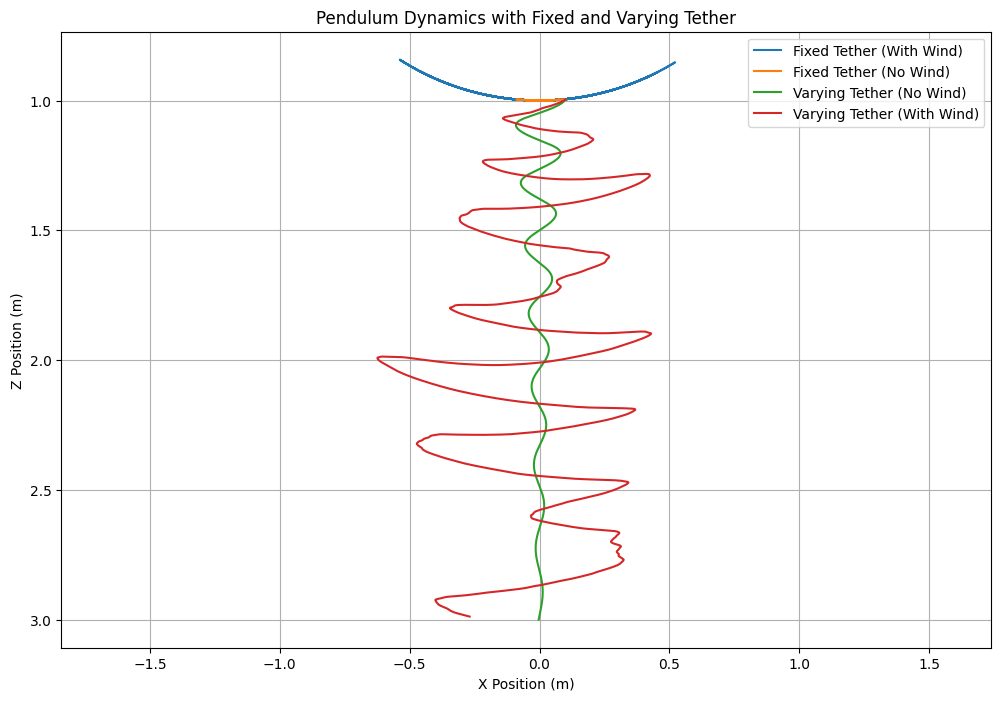

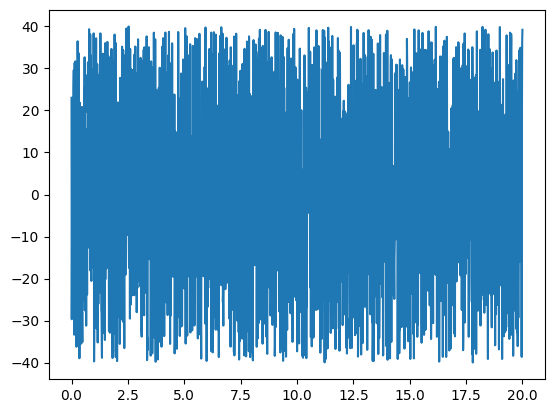

In [8]:
def dynamics_fixed(x, u, d):
    theta, theta_dot = x
    thrust = u[0]
    v_wind = d[0]
    theta_ddot = (thrust/(m*l0) - g/l0*jnp.sin(theta) + 
                 C_d/(m*l0)*(v_wind - l0*theta_dot))
    return jnp.array([theta_dot, theta_ddot])

def dynamics_varying(x, u, d):
    theta, theta_dot, ell = x
    thrust, ell_dot = u[0], u[1]
    v_wind = d[0]
    theta_ddot = (thrust/(m*ell) - (g/ell)*jnp.sin(theta) - 2*(ell_dot/ell)*theta_dot + 
                (C_d/(m*ell))*(v_wind - (ell_dot*jnp.sin(theta) + ell*jnp.cos(theta)*theta_dot))*jnp.cos(theta))
    return jnp.array([theta_dot, theta_ddot, ell_dot])

# Now JIT compile them
dynamics_fixed_jit = jit(dynamics_fixed)
dynamics_varying_jit = jit(dynamics_varying)

# JIT-compiled RK4 step with static_argnums for the dynamics function
@partial(jit, static_argnums=(0,))
def rk4_step(f, x, u, d, dt):
    k1 = f(x, u, d)
    k2 = f(x + 0.5 * dt * k1, u, d)
    k3 = f(x + 0.5 * dt * k2, u, d)
    k4 = f(x + dt * k3, u, d)
    return x + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

def simulate_system(dynamics, x0, u, wind_samples, dt, T_sim):
    N = int(T_sim / dt)
    xs = jnp.zeros((N, len(x0)))
    xs = xs.at[0].set(x0)
    
    def step(carry, i):
        x_prev = carry
        d = jnp.array([wind_samples[i]])
        x_next = rk4_step(dynamics, x_prev, u, d, dt)
        return x_next, x_next
    
    _, xs = jax.lax.scan(step, x0, jnp.arange(1, N))
    xs = jnp.concatenate([x0[jnp.newaxis, :], xs], axis=0)
    return xs

# Generate all wind samples upfront with fixed seed
wind_samples = random.uniform(key, (N,), minval=-v_wind_abs_max, maxval=v_wind_abs_max)

# Initial conditions
x0_fixed = jnp.array([theta0, theta_dot0])  # [theta, theta_dot]
x0_varying = jnp.array([theta0, theta_dot0, l0])  # [theta, theta_dot, ell]

# Control inputs
u_fixed = jnp.array([0.0])
u_varying = jnp.array([0.0, l_dot])

# Run simulations separately (can't JIT compile the whole thing due to different dynamics)
xs_fixed_no_wind = simulate_system(dynamics_fixed_jit, x0_fixed, u_fixed, jnp.zeros(N), dt, T_sim)
xs_varying_no_wind = simulate_system(dynamics_varying_jit, x0_varying, u_varying, jnp.zeros(N), dt, T_sim)
xs_fixed_wind = simulate_system(dynamics_fixed_jit, x0_fixed, u_fixed, wind_samples, dt, T_sim)
xs_varying_wind = simulate_system(dynamics_varying_jit, x0_varying, u_varying, wind_samples, dt, T_sim)

# Convert to numpy for plotting
xs_fixed_no_wind = np.array(xs_fixed_no_wind)
xs_varying_no_wind = np.array(xs_varying_no_wind)
xs_fixed_wind = np.array(xs_fixed_wind)
xs_varying_wind = np.array(xs_varying_wind)

# Rest of your plotting code...

# Plotting (same as before)
def get_xz_trace(theta_array, ell_array):
    x = ell_array * np.sin(theta_array)
    z = ell_array * np.cos(theta_array)
    return x, z

# ... rest of your plotting code ...

theta_fixed_no_wind = xs_fixed_no_wind[:, 0]
ell_fixed_no_wind = l0 * np.ones_like(theta_fixed_no_wind)
x_fixed_no_wind, z_fixed_no_wind = get_xz_trace(theta_fixed_no_wind, ell_fixed_no_wind)

theta_varying_no_wind = xs_varying_no_wind[:, 0]
ell_varying_no_wind = xs_varying_no_wind[:, 2]
x_varying_no_wind, z_varying_no_wind = get_xz_trace(theta_varying_no_wind, ell_varying_no_wind)

theta_fixed_with_wind = xs_fixed_wind[:, 0]
ell_fixed_with_wind = l0 * np.ones_like(theta_fixed_with_wind)
x_fixed_with_wind, z_fixed_with_wind = get_xz_trace(theta_fixed_with_wind, ell_fixed_with_wind)

theta_varying_with_wind = xs_varying_wind[:, 0]
ell_varying_with_wind = xs_varying_wind[:, 2]
x_varying_with_wind, z_varying_with_wind = get_xz_trace(theta_varying_with_wind, ell_varying_with_wind)

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(x_fixed_with_wind, z_fixed_with_wind, label='Fixed Tether (With Wind)')
plt.plot(x_fixed_no_wind, z_fixed_no_wind, label='Fixed Tether (No Wind)')
plt.plot(x_varying_no_wind, z_varying_no_wind, label='Varying Tether (No Wind)')
plt.plot(x_varying_with_wind, z_varying_with_wind, label='Varying Tether (With Wind)')
plt.title('Pendulum Dynamics with Fixed and Varying Tether')
plt.gca().invert_yaxis()
plt.axis('equal')
plt.xlabel('X Position (m)')
plt.ylabel('Z Position (m)')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(np.linspace(0,T_sim, N),wind_samples, label='Wind Speed Samples')

# Nominal PID controller

In [9]:

def PID_controller(dynamics, x0, u, dt, T_final, Kp, Ki, Kd, key):
    N = int(T_final / dt) 
    
    @partial(jit, static_argnames=['dynamics', 'N'])
    def _pid_inner(dynamics, x0, u, dt, Kp, Ki, Kd, key, N):
        # Generate all wind samples upfront
        wind_samples = random.uniform(key, (N,), minval=-v_wind_abs_max, maxval=v_wind_abs_max)
        
        def pid_step(carry, i):
            x, integral, prev_error = carry
            v_wind = wind_samples[i]
            d = jnp.array([v_wind])
            
            # PID calculations
            error = -x[0]
            integral = jnp.clip(integral + error * dt, -1.0, 1.0)  # Anti-windup
            derivative = (error - prev_error) / dt
            u_pid = Kp * error + Ki * integral + Kd * derivative
            
            # Clip thrust command to [-T_max_abs, T_max_abs]
            u_pid = jnp.clip(u_pid, -T_max_abs, T_max_abs)
            
            # Update control
            u_control = u.at[0].set(u_pid)
            
            # Step dynamics
            x_next = rk4_step(dynamics, x, u_control, d, dt)
            
            # Store results
            return (x_next, integral, error), (x_next, u_pid, error)
        
        # Initialize
        init_state = (x0, 0.0, 0.0)
        
        # Run simulation with scan
        _, (state_history, control_history, error_history) = lax.scan(
            pid_step,
            init_state,
            jnp.arange(N)
        )
        
        # Prepend initial state
        state_history = jnp.concatenate([x0[jnp.newaxis], state_history])
        control_history = jnp.concatenate([jnp.array([0.0]), control_history])
        error_history = jnp.concatenate([jnp.array([0.0]), error_history])
        
        return state_history, control_history, error_history, wind_samples
    
    return _pid_inner(dynamics, x0, u, dt, Kp, Ki, Kd, key, N)

# JIT-compiled RK4 step with static_argnums
@partial(jit, static_argnums=(0,))
def rk4_step(f, x, u, d, dt):
    k1 = f(x, u, d)
    k2 = f(x + 0.5 * dt * k1, u, d)
    k3 = f(x + 0.5 * dt * k2, u, d)
    k4 = f(x + dt * k3, u, d)
    return x + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

# JIT-compiled dynamics
dynamics_fixed_jit = jit(dynamics_fixed)
dynamics_varying_jit = jit(dynamics_varying)

# Run PID simulations with thrust clipping
pid_fixed_states, pid_fixed_controls, pid_fixed_error_history, pid_wind = PID_controller(
    dynamics_fixed_jit, 
    jnp.array([theta0, theta_dot0]), 
    jnp.array([0.0]), 
    dt=dt,
    T_final=T_sim,
    Kp = Kp,
    Ki = Ki,
    Kd = Kd,
    key=key
)

pid_varying_states, pid_varying_controls, pid_varying_error_history, _ = PID_controller(
    dynamics_varying_jit,
    jnp.array([theta0, theta_dot0, l0]),
    jnp.array([0.0, l_dot]),
    dt=dt,
    T_final=T_sim,
    Kp = Kp,
    Ki = Ki,
    Kd = Kd,
    key=key
)

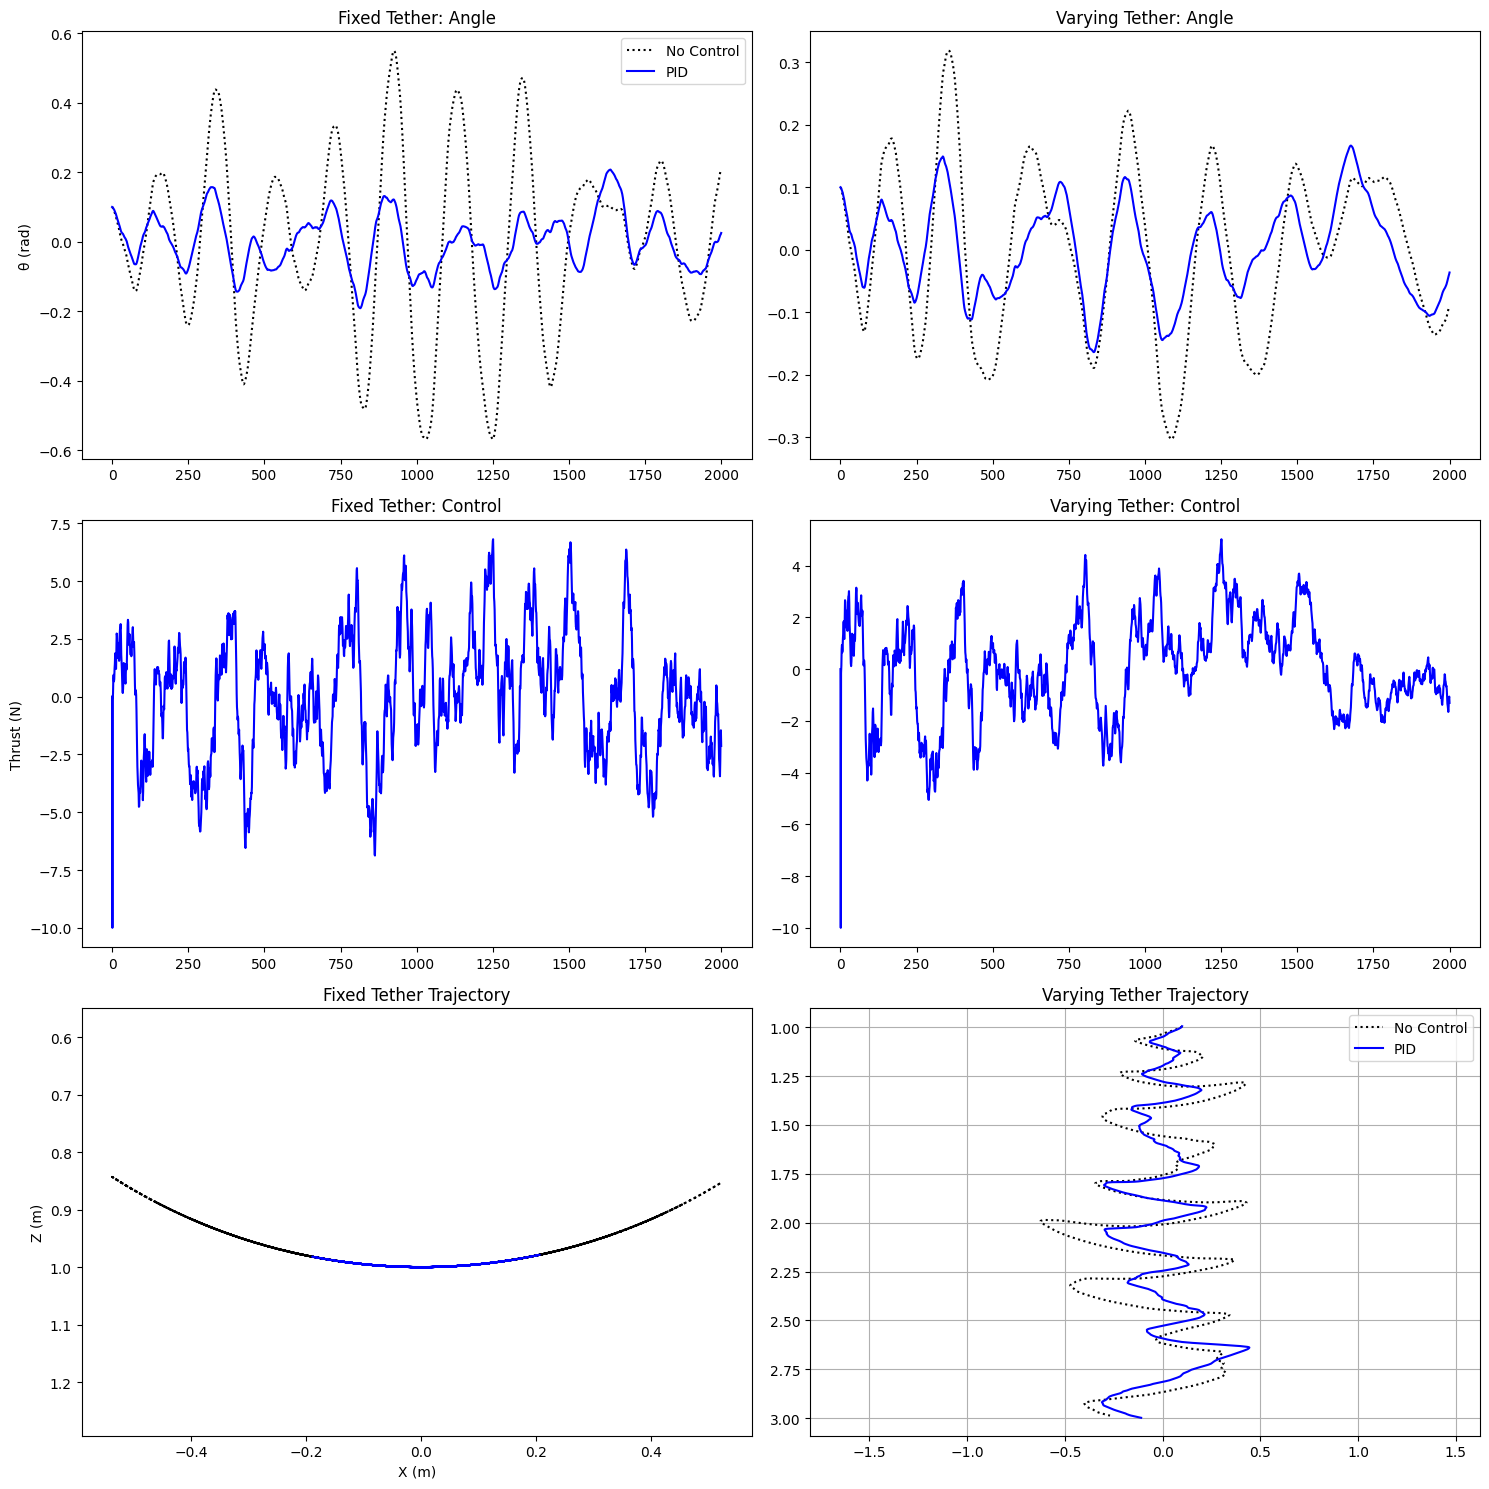

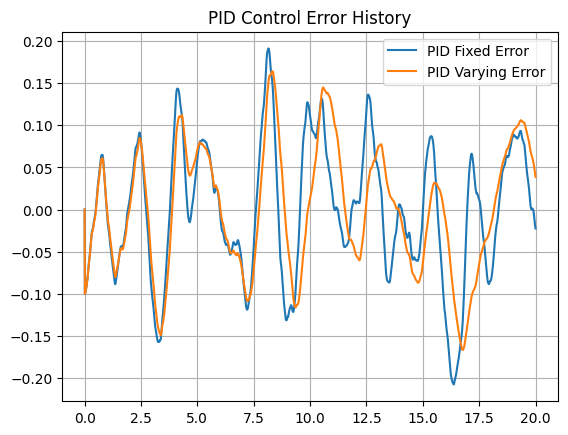

In [10]:
# Comparative Plotting
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# Angle responses
axs[0,0].plot(xs_fixed_wind[:,0], 'k:', label='No Control')
axs[0,0].plot(pid_fixed_states[:,0], 'b-', label='PID')
# axs[0,0].plot(lqr_fixed_states[:,0], 'r--', label='LQR')
axs[0,0].set_title('Fixed Tether: Angle')
axs[0,0].set_ylabel('θ (rad)')
axs[0,0].legend()

axs[0,1].plot(xs_varying_wind[:,0], 'k:')
axs[0,1].plot(pid_varying_states[:,0], 'b-')
# axs[0,1].plot(lqr_varying_states[:,0], 'r--')
axs[0,1].set_title('Varying Tether: Angle')

# Control inputs
axs[1,0].plot(pid_fixed_controls, 'b-')
# axs[1,0].plot(lqr_fixed_controls, 'r--')
axs[1,0].set_title('Fixed Tether: Control')
axs[1,0].set_ylabel('Thrust (N)')

axs[1,1].plot(pid_varying_controls, 'b-')
# axs[1,1].plot(lqr_varying_controls, 'r--')
axs[1,1].set_title('Varying Tether: Control')

# Trajectories
def plot_traj(ax, theta, l, color, label):
    x, z = l*np.sin(theta), l*np.cos(theta)
    ax.plot(x, z, color, label=label)
    ax.invert_yaxis()
    ax.axis('equal')

plot_traj(axs[2,0], xs_fixed_wind[:,0], l0, 'k:', 'No Control')
plot_traj(axs[2,0], pid_fixed_states[:,0], l0, 'b-', 'PID')
# plot_traj(axs[2,0], lqr_fixed_states[:,0], l0, 'r--', 'LQR')
axs[2,0].set_title('Fixed Tether Trajectory')
axs[2,0].set_xlabel('X (m)')
axs[2,0].set_ylabel('Z (m)')
axs[2,0].invert_yaxis()

plot_traj(axs[2,1], xs_varying_wind[:,0], xs_varying_wind[:,2], 'k:', 'No Control')
plot_traj(axs[2,1], pid_varying_states[:,0], pid_varying_states[:,2], 'b-', 'PID')
# plot_traj(axs[2,1], lqr_varying_states[:,0], lqr_varying_states[:,2], 'r--', 'LQR')
axs[2,1].set_title('Varying Tether Trajectory')
axs[2,1].invert_yaxis()

plt.tight_layout()
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.plot(np.linspace(0, T_sim, N+1), pid_fixed_error_history, label='PID Fixed Error')
plt.plot(np.linspace(0, T_sim, N+1), pid_varying_error_history, label='PID Varying Error')
plt.title('PID Control Error History')
plt.grid()
plt.legend()

# HJ BRT

### Defining our own dynamics compatible with hj_reachability toolbox
Our open-loop dynamics are (for no thrust, no wind):
\begin{align*}
\dot{x} &= f(x,0,0) = \begin{bmatrix}
\dot{\theta} \\
-\frac{g}{l}\sin{\theta}
-\frac{C_D}{m} \cos{\theta}\dot{\theta}
\end{bmatrix}
\end{align*}

The control Jacobian is:
\begin{align*}
B &= \frac{\partial f}{\partial u} = \begin{bmatrix}
0 \\
\frac{1}{ml}
\end{bmatrix}
\end{align*}

The disturbance Jacobian is:
\begin{align*}
E &= \frac{\partial f}{\partial d} = \begin{bmatrix}
0 \\
\frac{C_D}{ml}
\end{bmatrix}
\end{align*}

In [11]:
class FixedTetherPendulum(hj.ControlAndDisturbanceAffineDynamics):
    def __init__(self, m, l0, g, C_d, d_max, T_max,
                 control_mode="min", disturbance_mode="max"):
        control_space = hj.sets.Box(lo=jnp.array([-T_max]),
                                    hi=jnp.array([T_max]))
        disturbance_space = hj.sets.Box(lo=jnp.array([-d_max]),
                                        hi=jnp.array([d_max]))
        super().__init__(control_mode=control_mode,
                         disturbance_mode=disturbance_mode,
                         control_space=control_space,
                         disturbance_space=disturbance_space)
        self.m = m
        self.l0 = l0
        self.g = g
        self.C_d = C_d

    def open_loop_dynamics(self, state, time):
        theta, theta_dot = state
        return jnp.array([
            theta_dot,
            -self.g/self.l0 * jnp.sin(theta) - self.C_d * theta_dot / self.m
        ])

    def control_jacobian(self, state, time):
        return jnp.array([
            [0],
            [1 / (self.m * self.l0)]
        ])

    def disturbance_jacobian(self, state, time):
        return jnp.array([
            [0],
            [self.C_d / (self.m * self.l0)]
        ])
    
    def step(self, x, u, dt, d=None, time=0.0):
        """Integrate one time step using forward Euler (or pass to a better integrator)."""
        f = self.open_loop_dynamics(x, time)
        g = self.control_jacobian(x, time) @ jnp.atleast_1d(u)
        if d is not None:
            h = self.disturbance_jacobian(x, time) @ jnp.atleast_1d(d)
        else:
            h = 0.0
        x_dot = f + g + h
        return x + dt * x_dot


In [12]:
theta_max_abs = jnp.pi / 8         # ~22.5°
theta_dot_max_abs = jnp.pi / 4     # ~45°/s

grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(
    domain=hj.sets.Box(
        lo=jnp.array([-theta_max_abs, -theta_dot_max_abs]),
        hi=jnp.array([theta_max_abs, theta_dot_max_abs])
    ),
    shape=(100, 100),
    periodic_dims=None
)


In [19]:
theta_unsafe_radius = jnp.pi / 36  # ≈ 5°
values = -(jnp.abs(grid.states[..., 0]) - theta_unsafe_radius)



In [20]:
solver_settings = hj.SolverSettings.with_accuracy(
    "low",
    hamiltonian_postprocessor=hj.solver.backwards_reachable_tube
)

dynamics = FixedTetherPendulum(
    m=m, l0=l0, g=g, C_d=C_d,
    d_max=v_wind_abs_max, T_max=T_max_abs
)

time = 0.
target_time = -1.0  # simulate backwards in time
target_values = hj.step(
    solver_settings, dynamics, grid, time, values, target_time
)


  0%|          |  0.0000/1.0 [00:00<?, ?sim_s/s]

100%|##########|  1.0000/1.0 [00:01<00:00,  1.47s/sim_s]


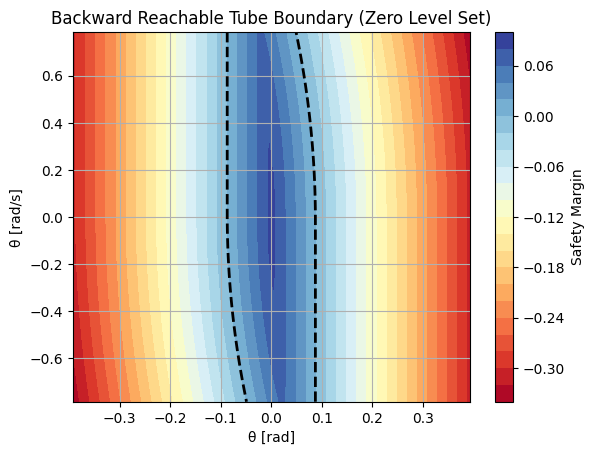

In [21]:
plt.contourf(
    grid.coordinate_vectors[0],
    grid.coordinate_vectors[1],
    target_values.T,
    levels=20,
    cmap='RdYlBu'
)
plt.colorbar(label='Safety Margin')

plt.contour(
    grid.coordinate_vectors[0],
    grid.coordinate_vectors[1],
    target_values.T,
    levels=[0],
    colors='black',
    linewidths=2,
    linestyles='dashed'
)

plt.xlabel("θ [rad]")
plt.ylabel("θ̇ [rad/s]")
plt.title("Backward Reachable Tube Boundary (Zero Level Set)")
plt.grid(True)
plt.show()


In [23]:
# Assuming grid is 2D: [θ, θ̇]
V_func = RegularGridInterpolator(
    (grid.coordinate_vectors[0], grid.coordinate_vectors[1]),
    target_values.T,  # transpose to align with (θ, θ̇)
    bounds_error=False,
    fill_value=None  # extrapolation allowed, or set to 0 if you want conservative behavior
)


In [24]:
def h(x):
    x_np = np.array(x)  # V_func expects NumPy, not JAX
    V_val = V_func(x_np)
    return -V_val  # negate so that h > 0 ⇒ safe

# CBF Safety Filter Controller

In [35]:
# Safety function
def h(x):
    """Returns positive when |θ| < theta_max"""
    return theta_max**2 - x[0]**2 - alpha*x[1]**2

# Pendulum dynamics (using JAX operations)
def dynamics_fixed(x, u, d):
    theta, theta_dot = x
    thrust = u[0]
    v_wind = d[0]
    theta_ddot = (thrust/(m*l0) - g/l0*jnp.sin(theta) + C_d/(m*l0)*(v_wind - l0*theta_dot))
    return jnp.array([theta_dot, theta_ddot])

def drift_field(x):
    theta, theta_dot = x
    theta_ddot = -(g/l0)*jnp.sin(theta) - (C_d/m)*theta_dot  # Wind set to 0 for drift
    return jnp.array([theta_dot, theta_ddot])

def control_field(x):
    return jnp.array([0.0, 1.0/(m*l0)])  # Constant control influence vector

# CBF safety filter with JAX grad but debuggable
def cbf_safe_filter(f, g, h, x, u_nom, kappa, epsilon):
    """Projects unsafe control inputs to safe ones"""
    # Use JAX's grad for accurate gradients
    grad_h = grad(h)(x)
    Lf_h = jnp.dot(grad_h, f(x))
    Lg_h = jnp.dot(grad_h, g(x))
    h_val = h(x)
    
    # CBF condition
    rhs = -kappa * h_val + (1.0/epsilon) * jnp.dot(Lg_h, Lg_h)
    
    # Debug prints (convert to numpy for readable output)
    print("\nCBF Debug:")
    print(f"State: θ={float(x[0]):.4f}, θ_dot={float(x[1]):.4f}")
    print(f"h(x)={float(h_val):.4f} (safe if >0)")
    print(f"Grad h: {np.array(grad_h)}")
    print(f"Lf_h: {float(Lf_h):.4f}, Lg_h: {float(Lg_h):.4f}") 
    print(f"Nominal control: {float(u_nom):.4f}")
    print(f"Safety threshold: {float(rhs):.4f}")

    def constraint(u):
        return jnp.dot(Lg_h, u) + Lf_h - rhs

    u = u_nom
    for i in range(10):  # Max projection steps
        constraint_val = constraint(u)
        print(f"Step {i}: control={float(u):.4f}, constraint={float(constraint_val):.4f}")
        
        if constraint_val >= 0:
            print("Control is safe!")
            break
            
        # Projection adjustment
        adjustment = 0.1 * (Lg_h / (jnp.linalg.norm(Lg_h)**2 + 1e-6)) * (rhs - jnp.dot(Lg_h, u) - Lf_h)
        u += adjustment
        u = jnp.clip(u, -T_max_abs, T_max_abs)
        print(f"Adjusted control: {float(u):.4f}")
    
    return u

# RK4 integration (using JAX ops)
def rk4_step(f, x, u, d, dt):
    k1 = f(x, u, d)
    k2 = f(x + 0.5*dt*k1, u, d)
    k3 = f(x + 0.5*dt*k2, u, d)
    k4 = f(x + dt*k3, u, d)
    return x + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

# PID controller
def pid_controller(x, integral, prev_error, dt):
    error = -x[0]
    integral = jnp.clip(integral + error*dt, -1.0, 1.0)
    derivative = (error - prev_error)/dt
    u_pid = Kp*error + Ki*integral + Kd*derivative
    return jnp.clip(u_pid, -T_max_abs, T_max_abs), integral, error

# Main simulation
def simulate():
    N = int(T_sim/dt)
    x = jnp.array([theta0, theta_dot0])
    integral = 0.0
    prev_error = 0.0
    
    # Initialize history (using lists for easier debugging)
    states = []
    controls = []
    h_vals = []
    wind = np.random.uniform(-v_wind_abs_max, v_wind_abs_max, N)
    
    for i in range(N):
        # Store state
        states.append(np.array(x))
        h_vals.append(float(h(x)))
        
        # PID control
        u_pid, integral, prev_error = pid_controller(x, integral, prev_error, dt)
        
        # CBF safety filter
        d = jnp.array([wind[i]])
        u_safe = cbf_safe_filter(drift_field, control_field, h, x, u_pid, kappa, epsilon)
        controls.append(float(u_safe))
        
        # Step dynamics
        x = rk4_step(dynamics_fixed, x, jnp.array([u_safe]), d, dt)
    
    return {
        'states': np.array(states),
        'controls': np.array(controls),
        'h_vals': np.array(h_vals),
        'wind': wind
    }

# Run simulation and store results in global variables
history = simulate()



CBF Debug:
State: θ=0.1000, θ_dot=-0.0500
h(x)=-0.0044 (safe if >0)
Grad h: [-0.2  0.1]
Lf_h: -0.0867, Lg_h: 0.0250
Nominal control: -10.0000
Safety threshold: 0.0845
Step 0: control=-10.0000, constraint=-0.4212
Adjusted control: -8.3179
Step 1: control=-8.3179, constraint=-0.3791
Adjusted control: -6.8038
Step 2: control=-6.8038, constraint=-0.3413
Adjusted control: -5.4409
Step 3: control=-5.4409, constraint=-0.3072
Adjusted control: -4.2140
Step 4: control=-4.2140, constraint=-0.2765
Adjusted control: -3.1096
Step 5: control=-3.1096, constraint=-0.2489
Adjusted control: -2.1155
Step 6: control=-2.1155, constraint=-0.2241
Adjusted control: -1.2206
Step 7: control=-1.2206, constraint=-0.2017
Adjusted control: -0.4151
Step 8: control=-0.4151, constraint=-0.1816
Adjusted control: 0.3100
Step 9: control=0.3100, constraint=-0.1634
Adjusted control: 0.9627

CBF Debug:
State: θ=0.0999, θ_dot=0.0370
h(x)=-0.0033 (safe if >0)
Grad h: [-0.19987075 -0.07407833]
Lf_h: 0.0658, Lg_h: -0.0185
Nomi

In [36]:
CBF_pid_fixed_states = history['states']
CBF_pid_fixed_controls = history['controls']

/var/folders/qs/76sxk8bx6y7d6061nqr8wgcm0000gq/T/ipykernel_7870/2448077542.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(t_noctrl, xs_fixed_wind[:, 0], 'k-',color = "pink", label='No control')


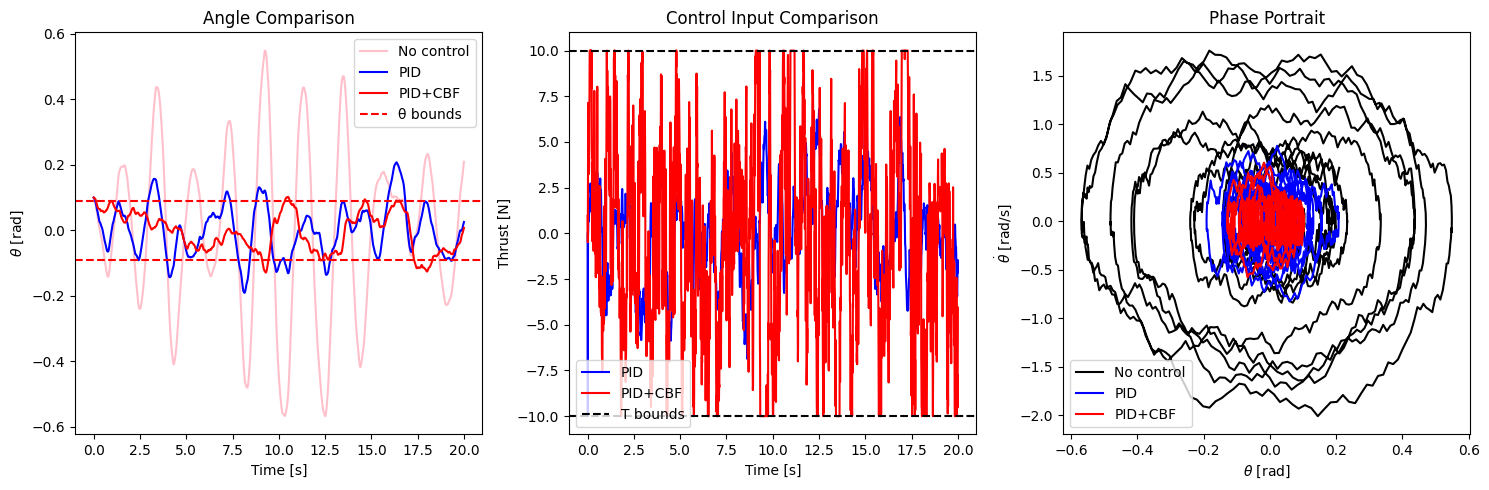

In [37]:
# Ensure time arrays match the lengths of the data arrays
t_noctrl = jnp.linspace(0, T_sim, xs_fixed_wind.shape[0])          # N+1
t_pid = jnp.linspace(0, T_sim, pid_fixed_states.shape[0])          # N+1
t_pidcbf = jnp.linspace(0, T_sim, CBF_pid_fixed_states.shape[0])   # N+1
t_controls = jnp.linspace(0, T_sim, pid_fixed_controls.shape[0])   # N

plt.figure(figsize=(15, 5))

# --- Angle comparison plot ---
plt.subplot(1, 3, 1)
plt.plot(t_noctrl, xs_fixed_wind[:, 0], 'k-',color = "pink", label='No control')
plt.plot(t_pid, pid_fixed_states[:, 0], 'b-', label='PID')
plt.plot(t_pidcbf, CBF_pid_fixed_states[:, 0], 'r-', label='PID+CBF')
plt.axhline(y=theta_max, color='r', linestyle='--', label='θ bounds')
plt.axhline(y=-theta_max, color='r', linestyle='--')
plt.xlabel('Time [s]')
plt.ylabel(r'$\theta$ [rad]')
plt.title('Angle Comparison')
plt.legend()

# --- Control input comparison plot ---
plt.subplot(1, 3, 2)
plt.plot(t_controls, pid_fixed_controls, 'b-', label='PID')
plt.plot(t_pidcbf, CBF_pid_fixed_controls, 'r-', label='PID+CBF')
plt.axhline(y=T_max_abs, color='k', linestyle='--', label='T bounds')
plt.axhline(y=-T_max_abs, color='k', linestyle='--')
plt.xlabel('Time [s]')
plt.ylabel('Thrust [N]')
plt.title('Control Input Comparison')
plt.legend()

# --- Phase portrait plot (θ vs θ̇) ---
plt.subplot(1, 3, 3)
plt.plot(xs_fixed_wind[:, 0], xs_fixed_wind[:, 1], 'k-', label='No control')
plt.plot(pid_fixed_states[:, 0], pid_fixed_states[:, 1], 'b-', label='PID')
plt.plot(CBF_pid_fixed_states[:, 0], CBF_pid_fixed_states[:, 1], 'r-', label='PID+CBF')
plt.xlabel(r'$\theta$ [rad]')
plt.ylabel(r'$\dot{\theta}$ [rad/s]')
plt.title('Phase Portrait')
plt.legend()

plt.tight_layout()
plt.show()


## For varying tether

In [38]:
def dynamics_varying(x, u, d):
    theta, theta_dot, ell = x
    thrust, ell_dot = u[0], u[1]
    v_wind = d[0]
    theta_ddot = (thrust/(m*ell) - (g/ell)*jnp.sin(theta) - 2*(ell_dot/ell)*theta_dot + 
                (C_d/(m*ell))*(v_wind - (ell_dot*jnp.sin(theta) + ell*jnp.cos(theta)*theta_dot))*jnp.cos(theta))
    return jnp.array([theta_dot, theta_ddot, ell_dot])

# Safety function (angle-only)
def h(x):
    theta, theta_dot, ell = x  # ℓ is unused but part of state
    return theta_max**2 - theta**2 - alpha * theta_dot**2  # Only penalize θ and θ_dot

# Drift field (u=0, ℓ_dot=constant)
def drift_field(x, ell_dot_const):
    theta, theta_dot, ell = x
    theta_ddot = - (g/ell)*jnp.sin(theta) - 2*(ell_dot_const/ell)*theta_dot + \
                 (C_d/(m*ell)) * (-ell_dot_const*jnp.sin(theta) - ell*jnp.cos(theta)*theta_dot) * jnp.cos(theta)
    return jnp.array([theta_dot, theta_dot, ell_dot_const])  # ℓ_dot fixed

# Control field (only thrust affects dynamics)
def control_field(x):
    theta, theta_dot, ell = x
    return jnp.array([0.0, 1.0/(m*ell), 0.0])  # thrust only affects θ_ddot

# CBF-PID Safety Filter (single-input)
def cbf_safe_filter(f, g, h, x, u_nom, ell_dot_const, kappa, epsilon):
    grad_h = grad(h)(x)[:2]  # Ignore ℓ gradient (safety only depends on θ, θ_dot)
    Lf_h = jnp.dot(grad_h, f(x, ell_dot_const)[:2])  # Only θ, θ_dot terms
    Lg_h = jnp.dot(grad_h, g(x)[:2])  # thrust effect on θ_ddot
    h_val = h(x)
    rhs = -kappa * h_val + (1.0/epsilon) * Lg_h**2

    def constraint(u):
        return Lf_h + Lg_h * u - rhs

    u = u_nom
    for _ in range(20):
        if constraint(u) >= 0:
            break
        # Project thrust only (ℓ_dot is constant)
        adjustment = 0.2 * (rhs - Lf_h - Lg_h * u) / (Lg_h + 1e-6)
        u += adjustment
        u = jnp.clip(u, -T_max_abs, T_max_abs)
    return u

# PID Controller (single-output: thrust)
def pid_controller(x, integral, prev_error, dt):
    theta, theta_dot, _ = x
    error = -theta
    integral = jnp.clip(integral + error * dt, -1.0, 1.0)
    u_pid = Kp * error + Ki * integral + Kd * theta_dot
    return jnp.clip(u_pid, -T_max_abs, T_max_abs), integral, error

# Simulation (constant ℓ_dot)
def simulate(ell_dot_const):
    N = int(T_sim / dt)
    x = jnp.array([theta0, theta_dot0, l0])
    integral = 0.0
    prev_error = 0.0
    states = []
    controls = []

    for _ in range(N):
        states.append(np.array(x))
        u_pid, integral, prev_error = pid_controller(x, integral, prev_error, dt)
        u_safe = cbf_safe_filter(drift_field, control_field, h, x, u_pid, ell_dot_const, kappa, epsilon)
        controls.append(float(u_safe))
        x = rk4_step(dynamics_varying, x, jnp.array([u_safe, ell_dot_const]), jnp.array([0.0]), dt)

    return {
        'states': np.array(states),
        'controls': np.array(controls)
    }

# Run simulation
history = simulate(ell_dot_const=l_dot)  # ℓ_dot fixed at 0.1 m/s
CBF_pid_varying_states = history['states']
CBF_pid_varying_controls = history['controls']

/var/folders/qs/76sxk8bx6y7d6061nqr8wgcm0000gq/T/ipykernel_7870/1961632431.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(t_noctrl, xs_varying_wind[:, 0], 'k-', color="pink", label='No control varying')
/var/folders/qs/76sxk8bx6y7d6061nqr8wgcm0000gq/T/ipykernel_7870/1961632431.py:37: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(xs_varying_wind[:, 0], xs_varying_wind[:, 1], 'k-', color="pink", label='No control')


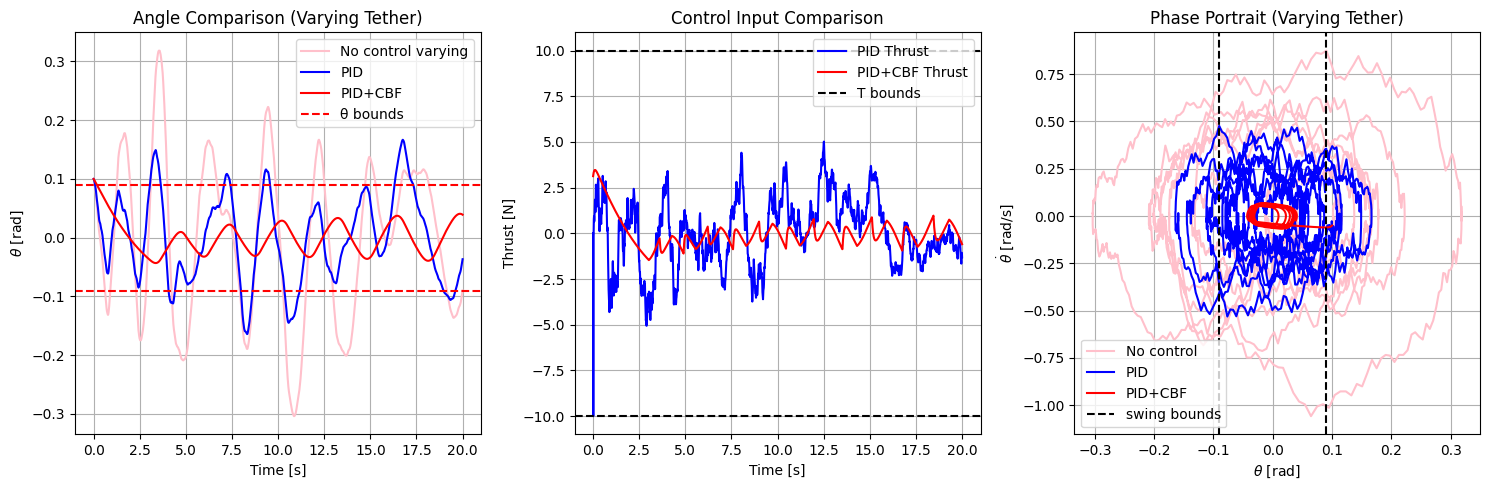

In [41]:
# Ensure time arrays match the lengths of the data arrays
t_noctrl = jnp.linspace(0, T_sim, xs_varying_wind.shape[0])          # N+1
t_pid = jnp.linspace(0, T_sim, pid_varying_states.shape[0])          # N+1
t_pidcbf = jnp.linspace(0, T_sim, CBF_pid_varying_states.shape[0])   # N+1
t_controls = jnp.linspace(0, T_sim, pid_varying_controls.shape[0])   # N

plt.figure(figsize=(15, 5))

# --- Angle comparison plot ---
plt.subplot(1, 3, 1)
plt.plot(t_noctrl, xs_varying_wind[:, 0], 'k-', color="pink", label='No control varying')
plt.plot(t_pid, pid_varying_states[:, 0], 'b-', label='PID')
plt.plot(t_pidcbf, CBF_pid_varying_states[:, 0], 'r-', label='PID+CBF')
plt.axhline(y=theta_max, color='r', linestyle='--', label='θ bounds')
plt.axhline(y=-theta_max, color='r', linestyle='--')
plt.xlabel('Time [s]')
plt.ylabel(r'$\theta$ [rad]')
plt.title('Angle Comparison (Varying Tether)')
plt.legend()
plt.grid()

# --- Control input comparison plot ---
plt.subplot(1, 3, 2)
plt.plot(t_controls, pid_varying_controls, 'b-', label='PID Thrust')
plt.plot(t_pidcbf, CBF_pid_varying_controls, 'r-', label='PID+CBF Thrust')
plt.axhline(y=T_max_abs, color='k', linestyle='--', label='T bounds')
plt.axhline(y=-T_max_abs, color='k', linestyle='--')
plt.xlabel('Time [s]')
plt.ylabel('Thrust [N]')
plt.title('Control Input Comparison')
plt.legend()
plt.grid()


# --- Phase portrait plot (θ vs θ̇) ---
plt.subplot(1, 3, 3)
plt.plot(xs_varying_wind[:, 0], xs_varying_wind[:, 1], 'k-', color="pink", label='No control')
plt.plot(pid_varying_states[:, 0], pid_varying_states[:, 1], 'b-', label='PID')
plt.plot(CBF_pid_varying_states[:, 0], CBF_pid_varying_states[:, 1], 'r-', label='PID+CBF')
plt.axvline(x=-theta_max, color='k', linestyle='--', label='swing bounds')
plt.axvline(x=theta_max, color='k', linestyle='--')
plt.xlabel(r'$\theta$ [rad]')
plt.ylabel(r'$\dot{\theta}$ [rad/s]')
plt.title('Phase Portrait (Varying Tether)')
plt.legend()
plt.grid()


plt.tight_layout()
plt.show()

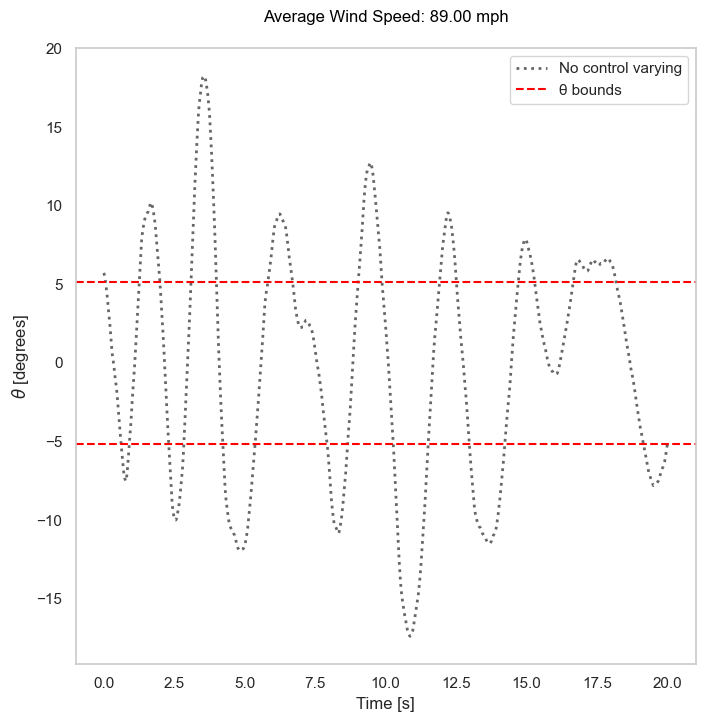

In [60]:
import seaborn as sns

# Convert radians to degrees
theta_varying_wind_deg = np.rad2deg(xs_varying_wind[:, 0])  # θ in degrees
theta_pid_varying_deg = np.rad2deg(pid_varying_states[:, 0])  # θ in degrees
theta_cbf_pid_varying_deg = np.rad2deg(CBF_pid_varying_states[:, 0])  # θ in degrees
theta_max_deg = np.rad2deg(theta_max)  # θ bounds in degrees

# Convert wind speed to mph (assuming wind_samples is in m/s)
wind_speed_mph = int(v_wind_abs_max * 2.23694)  # Conversion factor: 1 m/s = 2.23694 mph

# Set Seaborn style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(8, 8))
sns.lineplot(x=t_noctrl, y=theta_varying_wind_deg, label='No control varying', color="black", linestyle=':', alpha=0.6, linewidth=2)
# sns.lineplot(x=t_pid, y=theta_pid_varying_deg, label='PID', color="blue", linestyle='--', linewidth=2)
# sns.lineplot(x=t_pidcbf, y=theta_cbf_pid_varying_deg, label='PID+CBF', color="green", linewidth=2)

# Add horizontal lines for bounds
plt.axhline(y=theta_max_deg, color='red', linestyle='--', label='θ bounds')
plt.axhline(y=-theta_max_deg, color='red', linestyle='--')

# Add wind speed note
plt.text(0.5, 1.05, f"Average Wind Speed: {wind_speed_mph:.2f} mph", 
         horizontalalignment='center', verticalalignment='center', 
         transform=plt.gca().transAxes, fontsize=12, color='black')

# Customize labels and title
plt.xlabel('Time [s]')
plt.ylabel(r'$\theta$ [degrees]')
# plt.title('Angle Comparison (Varying Tether)')
plt.legend()
plt.grid()

# Show the plot
plt.show()

/var/folders/qs/76sxk8bx6y7d6061nqr8wgcm0000gq/T/ipykernel_7870/277905718.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(theta_varying_wind_deg, theta_dot_varying_wind_deg, 'k-', color="pink", label='No control')


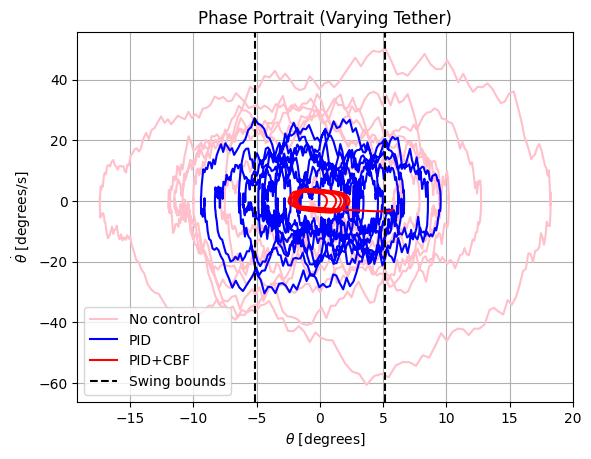

In [43]:
# Convert radians to degrees
theta_varying_wind_deg = np.rad2deg(xs_varying_wind[:, 0])  # θ in degrees
theta_dot_varying_wind_deg = np.rad2deg(xs_varying_wind[:, 1])  # θ̇ in degrees/s

theta_pid_varying_deg = np.rad2deg(pid_varying_states[:, 0])  # θ in degrees
theta_dot_pid_varying_deg = np.rad2deg(pid_varying_states[:, 1])  # θ̇ in degrees/s

theta_cbf_pid_varying_deg = np.rad2deg(CBF_pid_varying_states[:, 0])  # θ in degrees
theta_dot_cbf_pid_varying_deg = np.rad2deg(CBF_pid_varying_states[:, 1])  # θ̇ in degrees/s

theta_max_deg = np.rad2deg(theta_max)  # θ bounds in degrees

# Plotting
plt.plot(theta_varying_wind_deg, theta_dot_varying_wind_deg, 'k-', color="pink", label='No control')
plt.plot(theta_pid_varying_deg, theta_dot_pid_varying_deg, 'b-', label='PID')
plt.plot(theta_cbf_pid_varying_deg, theta_dot_cbf_pid_varying_deg, 'r-', label='PID+CBF')
plt.axvline(x=-theta_max_deg, color='k', linestyle='--', label='Swing bounds')
plt.axvline(x=theta_max_deg, color='k', linestyle='--')
plt.xlabel(r'$\theta$ [degrees]')
plt.ylabel(r'$\dot{\theta}$ [degrees/s]')
plt.title('Phase Portrait (Varying Tether)')
plt.legend()
plt.grid()
plt.show()